# Notebook for computing CLVs of the Lorenz 63 system

In [49]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
from scipy.linalg import expm
from mpl_toolkits.mplot3d import Axes3D

In [50]:
# Function to ensure QR decomposition has positive diagonals

def posQR(M):
    """ Returns QR decomposition of a matrix with positive diagonals on R.
    Parameter, M: Array that is being decomposed
    """
    Q, R = np.linalg.qr(M) # Performing QR decomposition
    signs = np.diag(np.sign(np.diagonal(R))) # Matrix with signs of R diagonal on the diagonal
    Q, R = np.dot(Q, signs), np.dot(signs, R) # Ensuring R Diagonal is positive
    return Q, R

### Time Parameters

In [228]:
dt = 1.e-2 # Time step for numerical integration, this is also the interval TLE is solved over
tao = int(25) # How many steps TLE pushes you forward
kA = int(1.e2) # BLV convergence
kB = int(2.e2) # Number of places we sample LVs and LEs
kC = kA # CLV convergence
tA = kA * tao # Number of stps
tB = kB * tao
tC = kC * tao
steps = tA + tB + tC # total number of steps
print(f'Total time we are solving L63 for is {steps * dt}\nSampling LVs and LEs at {kB} steps.')

Total time we are solving L63 for is 100.0
Sampling LVs and LEs at 200 steps.


## Solving and Plotting Lorenz 63

In [229]:
# L63 Definition

#Parameters
a = 10.0
b = 8/3
c = 28.0
p = [a, b, c]

def L63(state, t, p):
    """ ODEs defining Lorenz 63 system.
    Parameter, state: current state.
    Parameter, t: time.
    Parameter, p: array, parameters for L63.
    """
    [a, b, c] = p
    x, y, z = state
    dxdt = a * (y - x)
    dydt = (c * x) - y - (x * z)
    dzdt = (x * y) - (b * z)
    dudt = np.array([dxdt, dydt, dzdt])
    return dudt

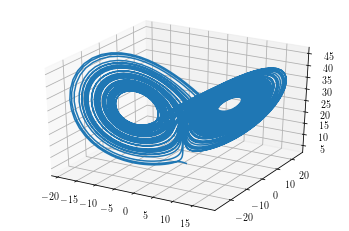

In [230]:
# Solving L63 Numerically using odeint

IC = np.array([3, -5.1, 5.1])
time = np.arange(0, steps * dt, dt)
solution = odeint(L63, IC, time, (p,))

# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')


# tangentVectors = np.zeros(solution.shape)


# for i in np.arange(solution.shape[0]):
#     tangentVectors[i] = L63(solution[i], 1, p)


# x = solution[:, 0]   
# y = solution[:, 1] 
# z = solution[:, 2] 
# u = tangentVectors[:, 0]
# v = tangentVectors[:, 1]
# w = tangentVectors[:, 2]



# ax.quiver(x, y, z, u, v, w, length=1, normalize=True,color='r' )
ax.plot(solution[:, 0], solution[:, 1], solution[:, 2])
plt.show()

# Tangent Vector Plot

In [231]:
tangentVectors = np.zeros(solution.shape) # Tangent Vectors to the flow
for i in np.arange(solution.shape[0]):
    tangentVectors[i] = L63(solution[i], 1, p)

# Plotting Tangent Vectors

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# x = solution[:, 0]   
# y = solution[:, 1] 
# z = solution[:, 2] 
# u = tangentVectors[:, 0]
# v = tangentVectors[:, 1]
# w = tangentVectors[:, 2]
# ax.plot(solution[:, 0], solution[:, 1], solution[:, 2])
# ax.quiver(x, y, z, u, v, w, length=1, normalize=True,color='r' )

## Function for Jacobians

We will only need the jacobians after the transient period.

In [232]:
# Function to calucate Jacobian of L63 at a point on trajectory

def Jacobian(location, parameters):
    """Returns the jacobian matrix at a given point of L63.
    Param, location, array: [x, y, z] coordinates.
    Parameters, parameters, L63 parameters.
    """
    [a, b, c] = parameters
    [x, y, z] = location
    row1 = np.array([-a, a, 0])
    row2 = np.array([c - z, -1, -x])
    row3 = np.array([y, x, -b])
    J = np.array([row1, row2, row3])
    return J

# Test of Jacobian Function
# location = [2, 0, 1]
# print(Jacobian(location, [a, b, c]))

## Solving the Tangent Linear Equations

At each point along trajectory of L63 we define a TLE. We solve this numerically with Q_k as the IC. The solution our numerical integration gives is P_k = Q_k R_k. Never need the propagator!

#### First we define eveything we need for the TLEs

In [233]:
# Function that defines RHS of TLE
def TLE(delta, time, p, state):
    """Defines RHS of the TLE at a given point on attractor.
    Param, delta, perturbation evolution being solved for.
    Param, time.
    Param, p, parameters of Lorenz system.
    Param, state, where we are on the attractor.
    """
    J = Jacobian(state, p)
    f = np.dot(J, delta)
    return f

#### Function that solves TLE

In [234]:
def solveTLE(state, oldQ, time):
    """ Solves tangent linear equation.
    Param, state, array: where we are on the attractor, used to define TLE.
    Param, oldQ, IC of TLE being solved. 
    Param, time, timesteps we solve TLE for.
    """
    TLEsolution0 = odeint(TLE, oldQ[:, 0], time, (p, state)) # Solving the TLE for different IC
    col1 = TLEsolution0[-1]
    TLEsolution1 = odeint(TLE, oldQ[:, 1], time, (p, state))
    col2 = TLEsolution1[-1]
    TLEsolution2 = odeint(TLE, oldQ[:, 2], time, (p, state))
    col3 = TLEsolution2[-1]
    Pk = np.column_stack((col1, col2, col3))
    return Pk

## Ginelli Algorithm for calculating the CLVs

Matrices for storage.

In [235]:
Qs = np.zeros((3, 3, int(kB))) # BLVs. Last index is time. 
Rs = np.zeros((3, 3, int(kB))) # Stretching rates
Rs2 = np.zeros((3, 3, int(kC))) # Stretching rates
CLVs = np.zeros((3, 3, int(kB)))
FTBLE = np.zeros((int(kB), 3)) # To store time series of FTBLES
BLE = np.zeros((kB, 3)) # Storing running mean of FTBLEs
FTCLE = np.zeros((int(kB), 3)) # To store time series of FTBLES
CLE = np.zeros((kB, 3)) # Storing running mean of FTBLEs

tangentVectors = np.zeros((int(kB), 3))

### Step 1: Converge to the BLVs via Benettin Stepping

Initialising an orthogonal matrix.

In [236]:
eps = 0.01
oldQ = eps * np.identity(3)

In [237]:
for i in np.arange(0, tA, tao):
    
    for j in range(tao): # Solve TLE
        state = solution[i + j]
        time = np.array([(i + j) * dt, (i + j + 1) * dt])
        Pk = solveTLE(state, oldQ, time)
        oldQ = Pk
        
    oldQ, R = posQR(Pk) # Performing Q, R decomposition with positive diagonal

### Step 2: More Benettin stepping. We begin sampling FTBLEs. We also store BLVs.

In [238]:
for i in np.arange(0, tB, tao):    
    k = tA + i
    
    for j in range(tao): # Solve TLE
        state = solution[k + j]
        time = np.array([(k + j) * dt, (k + j + 1) * dt])
        Pk = solveTLE(state, oldQ, time)
        oldQ = Pk
    
    oldQ, R = posQR(Pk) # Performing Q, R decomposition with positive diagonals
    
    # Storage
    ftble = np.log(np.diag(R))/(tao * dt) # Note division by k * dt is done here
    
    #print(f'Index {int(i/tao)}\n\nPk is\n{Pk}\n\n Q is\n {oldQ}\n\n R is\n {R}\n') 
    FTBLE[int(i/tao)] = ftble
    BLE[int(i/tao)] = np.mean(FTBLE[0:int(i/tao) + 1], axis = 0)
    Qs[:,:, int(i/tao)], Rs[:, :, int(i/tao)] = oldQ, R
    #print(f'Stored Q is\n {Qs[:,:, int(i/tao)]}\n\n Stored R is\n {Rs[:,:, int(i/tao)]}\n\n') # Storage is correct 11.02.20

In [239]:
# time = (np.arange(0, tB, tao) + tA) * dt
# plt.plot(time, FTBLE[:,0], label='FTBLE')
# plt.plot(time, BLE[:,0], label='BLE',marker=".")
# test=2
# plt.plot(time, np.ones(BLE[:,0].shape[0]) * np.mean(FTBLE[:test,0]), label='FTBLE Mean')
# plt.legend()
# print(FTBLE[:,0])
# print(np.mean(FTBLE[0:2], axis=0))
# print(BLE[:,0])

### Step 3: More Benettin steps. Now only storing Rs.

In [240]:
for i in np.arange(0, tC, tao):    
    k = tA + tB + i
    
    for j in range(tao): # Solve TLE
        state = solution[k + j]
        time = np.array([(k + j) * dt, (k + j + 1) * dt])
        Pk = solveTLE(state, oldQ, time)
        oldQ = Pk
    
    oldQ, R = posQR(Pk) # Performing Q, R decomposition with positive diagonals

    # Storage
    Rs2[:, :, int(i/tao)] =  R

### Step 4: Time to go back, converging to A- matrix (Coefficient matrix of CLVs in BLV basis)



We will evolve upper triangular matrix backward to timeB using the stored $R$'s from Step 3. This should converge to $A^-$ of $QR$ decomposition of CLVs $\Gamma = \phi^- A^-$

In [241]:
# Initialise an upper triangular matrix
A = np.identity(3)
A[0,1] = 1
oldA = A

for i in np.arange(0, tC, tao):    
    
    # Pushing A- backwards with R's
    Rinv = np.linalg.inv(Rs2[:, :, kC - int(i/tao) - 1])
    newA = np.matmul(Rinv, oldA)
    oldA = newA
      
    # Normalises A's to prevent overflow
    oldA = oldA/np.diag(oldA)

### Step 5: Keep going back, finding CLVs. Sample FTCLEs here.

In [242]:
for i in np.arange(0, tB, tao):
        
    # Pushing A- backwards with R's
    Rinv = np.linalg.inv(Rs[:, :, kB - int(i/tao) - 1])
    newA = np.matmul(Rinv, oldA)
    
    # Sampling FTCLE 
    ftcle = - np.log(np.diag(newA))/(tao * dt) # Calculating FTCLE at step. Note division by dt is done here. 
    #ftcle = -np.log(np.linalg.norm(oldA, axis=0, ord=2))/(tao * dt)
    # Notice ^ Minus sign for contraction
    FTCLE[int(i/tao)] = ftcle
    CLE[int(i/tao)] = np.mean(FTCLE[0:int(i/tao) + 1], axis = 0) # Time series of estimated LE spectrum from FTCLEs
    
    # Calculate CLV, using A- and BLV
    BLV = Qs[:,:, kB - int(i/tao) - 1]
    CLVs[:, :, kB - int(i/tao) - 1] = np.matmul(BLV, newA)
    
    # Tangent Vector
    where = solution[kB - int(i/tao) - 1]
    tangentVectors[kB - int(i/tao) - 1] = L63(where, 1, p)
    
    oldA = newA   
        
    # Normalises A's to prevent overflow
#     norms = np.linalg.norm(oldA, axis=0, ord=2) # L2 of column norms. Think this is FTCLE?
#     oldA = oldA/norms 
    oldA = oldA/np.diag(oldA)

# Time Series Plots

## Plots of FTLEs Running Average

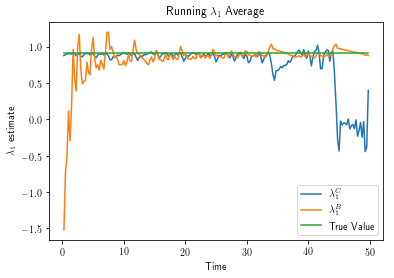

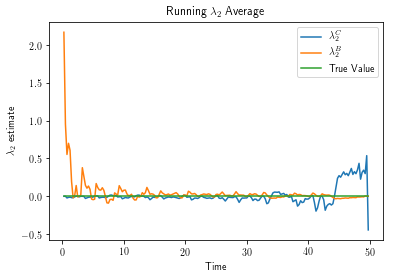

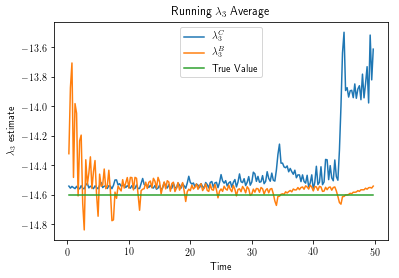

In [243]:
from matplotlib import rc
rc('text', usetex=True)

j = 1 # Time we plot from
length = CLE[j:, 0].shape[0]
time = tao * dt * (np.arange(length) + j)

# First LE
plt.plot(time, np.flip(CLE[j:, 0], axis = 0), label='$\lambda_1 ^C$')
plt.plot(time, BLE[j:, 0], label='$\lambda_1 ^B$')
plt.plot(time, 0.91 * np.ones(length), label = 'True Value') # Literature value
#plt.plot(np.arange(length), means[0] * np.ones(length)) # Plotting mean value
plt.xlabel('Time')
plt.ylabel('$\lambda_1$ estimate')
plt.title('Running $\lambda_1$ Average')
plt.legend()
plt.savefig('First-LE.png')

# Second LE
plt.figure()
plt.plot(time, np.flip(CLE[j:, 1], axis=0), label='$\lambda_2 ^C$')
plt.plot(time, BLE[j:, 1], label='$\lambda_2 ^B$')
plt.plot(time, 0 * np.ones(length), label = 'True Value') # Literature value
#plt.plot(np.arange(length), means[0] * np.ones(length)) # Plotting mean value
plt.xlabel('Time')
plt.ylabel('$\lambda_2$ estimate')
plt.title('Running $\lambda_2$ Average')
plt.legend()
plt.savefig('Second-LE.png')

# Third LE
plt.figure()
plt.plot(time, np.flip(CLE[j:, 2], axis=0), label='$\lambda_3 ^C$')
plt.plot(time, BLE[j:, 2], label='$\lambda_3 ^B$')
plt.plot(time, -14.6 * np.ones(length), label = 'True Value') # Literature value
#plt.plot(np.arange(length), means[0] * np.ones(length)) # Plotting mean value
plt.xlabel('Time')
plt.ylabel('$\lambda_3$ estimate')
plt.title('Running $\lambda_3$ Average')
plt.legend()
plt.savefig('Third-LE.png')

### Mean (this will be LEs)

In [244]:
print(f'The averaged value of the FTBLEs is {np.mean(FTBLE, axis = 0)}.\n')
print(f'The averaged value of the FTCLEs is {np.mean(FTCLE, axis = 0)}.\n')
print(f'Difference is {np.mean(FTBLE, axis=0) - np.mean(FTCLE, axis=0)}')

The averaged value of the FTBLEs is [ 8.79894603e-01 -5.34035121e-03 -1.45412052e+01].

The averaged value of the FTCLEs is [ 8.79894603e-01 -5.34035121e-03 -1.45412052e+01].

Difference is [-4.44089210e-16 -2.08166817e-17  7.10542736e-15]


## Check sum

The sum of the LEs is -13.666650920831248. It should be -13.666666666666666.


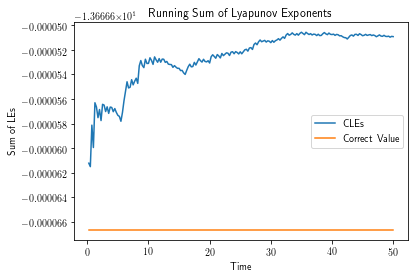

In [245]:
print(f'The sum of the LEs is {np.sum(CLE[-1])}. It should be {-1 - a -b}.')

length = CLE.shape[0]
time = tao * dt * (np.arange(length) + j)
plt.plot(time, np.sum(CLE, axis=1), label='CLEs')
plt.plot(time, (-1 - a -b) * np.ones(CLE.shape[0]), label='Correct Value')
plt.xlabel('Time')
plt.ylabel('Sum of LEs')
plt.title('Running Sum of Lyapunov Exponents')
plt.legend()

### Variance

In [246]:
print(f'For the FTBLE we have: \n\nVariance {np.var(FTBLE, axis = 0)}.\n\nSD is {np.std(FTBLE, axis = 0)}.\n')
print(f'For the FTCLE we have: \n\nVariance {np.var(FTCLE, axis = 0)}.\n\nSD is {np.std(FTCLE, axis = 0)}.\n')
print(f'Difference in varinace is {np.var(FTBLE, axis=0) - np.var(FTCLE, axis=0)}')

For the FTBLE we have: 

Variance [13.47431405  3.08512967  9.68216874].

SD is [3.67073753 1.75645372 3.11161835].

For the FTCLE we have: 

Variance [13.47431405  3.08512967  9.68216874].

SD is [3.67073753 1.75645372 3.11161835].

Difference in varinace is [-1.77635684e-15  0.00000000e+00  0.00000000e+00]


### Histograms

In [247]:
np.allclose(FTBLE[:,0], np.flip(FTCLE[:,0], 0)) # Time series the same up to compute precision, just reversed

True

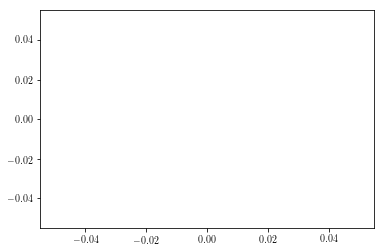

In [248]:
plt.plot(FTCLE[500:700,0])
#plt.plot(np.flip(FTCLE[500:600,0], 0))

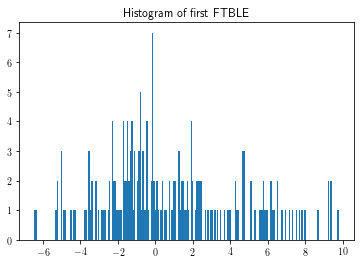

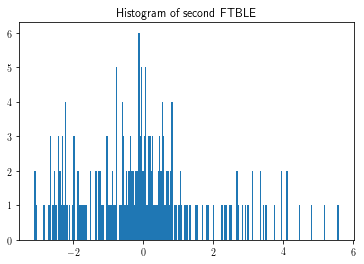

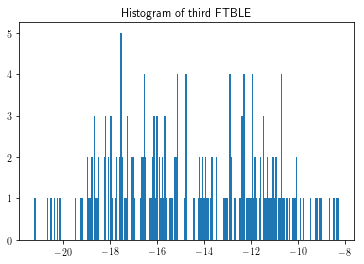

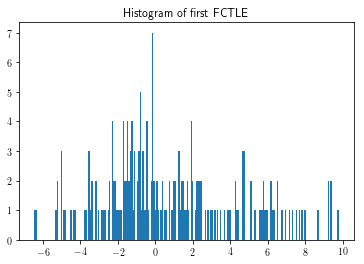

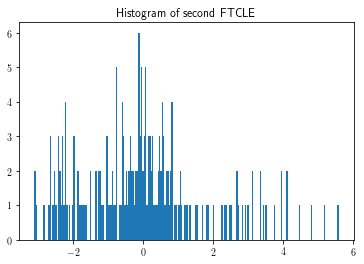

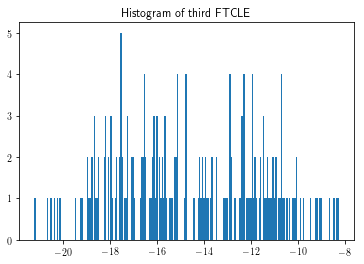

In [159]:
plt.hist(FTBLE[:,0], bins = 220) # Specify wheter you want FTCLE and which le
plt.title("Histogram of first FTBLE")
plt.savefig("FTBLE1-Histogram.png")

plt.figure()
plt.hist(FTBLE[:,1], bins = 220)
plt.title("Histogram of second FTBLE")
plt.savefig("FTBLE2-Histogram.png")


plt.figure()
plt.hist(FTBLE[:,2], bins = 220)
plt.title("Histogram of third FTBLE")
plt.savefig("FTBLE3-Histogram.png")

# Covariant

plt.figure()
plt.hist(FTCLE[:,0], bins = 220)
plt.title("Histogram of first FCTLE")
plt.savefig("FTCLE1-Histogram.png")

plt.figure()
plt.hist(FTCLE[:,1], bins = 220)
plt.title("Histogram of second FTCLE")
plt.savefig("FTCLE2-Histogram.png")

plt.figure()
plt.hist(FTCLE[:,2], bins = 220)
plt.title("Histogram of third FTCLE")
plt.savefig("FTCLE3-Histogram.png")

### Pearson correlation coefficient

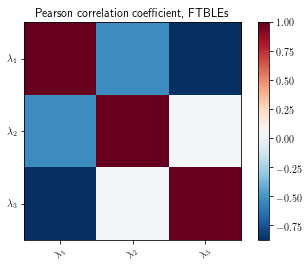

<Figure size 432x288 with 0 Axes>

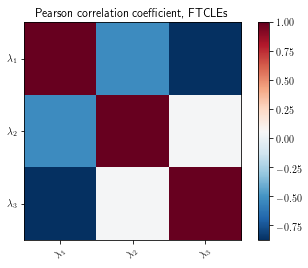

In [160]:
covm = np.corrcoef(FTBLE.T) # Calculating Pearson correlation coefficient
#use np.cov for covariance

#Illustrating covariance matric as heatmap
fig, ax = plt.subplots() 
im = ax.imshow(covm, cmap='RdBu_r')

names = np.array(['$\lambda_1$', '$\lambda_2$', '$\lambda_3$']) # Labels
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Pearson correlation coefficient, FTBLEs")
cbar = plt.colorbar(im)# Colorbar
# plt.show()
plt.savefig("FTBLE-Pearson.png")

#For the FTCLE
plt.figure()

covm = np.corrcoef(FTCLE.T) # Calculating Pearson correlation coefficient
#use np.cov for covariance

#Illustrating covariance matric as heatmap
fig, ax = plt.subplots() 
im = ax.imshow(covm, cmap='RdBu_r')

names = np.array(['$\lambda_1$', '$\lambda_2$', '$\lambda_3$']) # Labels
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Pearson correlation coefficient, FTCLEs")
cbar = plt.colorbar(im)# Colorbar
plt.savefig("FTCLE-Pearson.png")



### Kaplan Yorke Dimension

In [161]:
# kydim = 2 + ((means[0] + means[1])/abs(means[2]))
# print(f'Kaplan Yorke Dimension is {kydim}')

# Angles

In [249]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [257]:
angles = np.zeros((kB, 3)) # Indexed by [time, (angle of:) (1,2), (1,3), (2,3)]
bangles= angles

for t in np.arange(kB):
    angles[t, 0] = angle_between(CLVs[:,0,t], CLVs[:,1,t])
    angles[t, 1] = angle_between(CLVs[:,0,t], CLVs[:,2,t])
    angles[t, 2] = angle_between(CLVs[:,1,t], CLVs[:,2,t])


# Investigating angles

### Verifying BLVs are Orthogonal

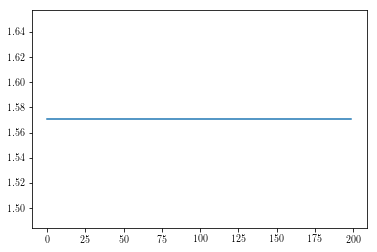

In [258]:
for t in np.arange(kB):
    bangles[t, 0] = angle_between(Qs[:,0,t], Qs[:,1,t])
    bangles[t, 1] = angle_between(Qs[:,0,t], Qs[:,2,t])
    bangles[t, 2] = angle_between(Qs[:,1,t], Qs[:,2,t])
    
plt.plot(bangles[:, 2]) #These are 90 degrees as expected

### Comparing Angle between second CLV and tangent vectors

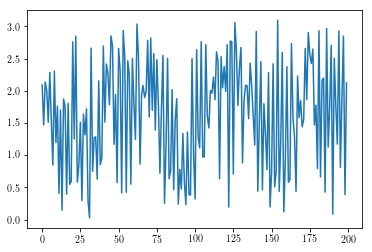

In [259]:
tangles = np.zeros(kB)
for t in np.arange(kB):
    tangles[t] = angle_between(tangentVectors[t], CLVs[:,1,t].T)

plt.plot(tangles)

In [111]:
print(solution.shape)


# x = solution[:, 0]   
# y = solution[:, 1] 
# z = solution[:, 2] 
# u = tangentVectors[:, 0]
# v = tangentVectors[:, 1]
# w = tangentVectors[:, 2]



# ax.quiver(x, y, z, u, v, w, length=1, normalize=True,color='r' )
# ax.plot(solution[:, 0], solution[:, 1], solution[:, 2])
# plt.show()

(750, 3)


# Basic angle stats

In [262]:
print(f'The averaged angles are {np.mean(angles, axis = 0)}.\n')
print(f'where: \n\nVariance {np.var(angles, axis = 0)}.\n\nSD is {np.std(angles, axis = 0)}.\n')

print(angles[0])

The averaged angles are [1.57079633 1.57079633 1.57079633].

where: 

Variance [1.64896581e-29 1.65194869e-29 1.65636138e-29].

SD is [4.06074600e-15 4.06441717e-15 4.06984199e-15].

[1.57079633 1.57079633 1.57079633]


Looks like there are points where the center manifold and the unstable manifold get closer.

# Histograms

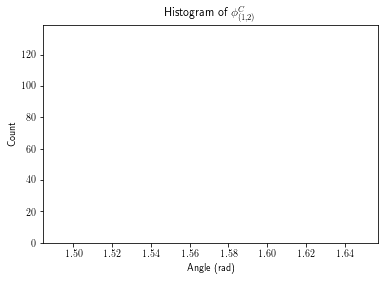

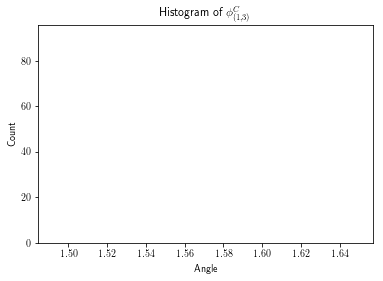

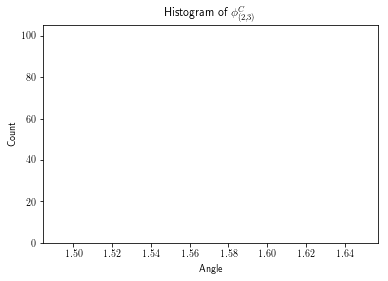

In [261]:
plt.hist(angles[:,0], bins = 200) # Specify wheter you want FTCLE and which le
plt.title("Histogram of $\phi _{(1,2)}^C$")
plt.xlabel('Angle (rad)')
plt.ylabel('Count')
plt.savefig('Angles12.png')

plt.figure()
plt.hist(angles[:,1], bins = 200) # Specify wheter you want FTCLE and which le
plt.title("Histogram of $\phi _{(1,3)}^C$")
plt.xlabel('Angle')
plt.ylabel('Count')
plt.savefig('Angles13.png')


plt.figure()
plt.hist(angles[:,2], bins = 200) # Specify wheter you want FTCLE and which le
plt.title("Histogram of $\phi _{(2,3)}^C$")
plt.xlabel('Angle')
plt.ylabel('Count')
plt.savefig('Angles23.png')

[ 0.21475232 -0.34156349 -1.43999735]
[-5.47870517e+18  8.71387878e+18  3.67368373e+19]


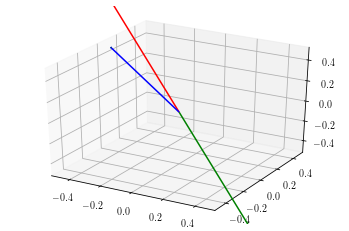

In [560]:
t = 2000
print(CLVs[:,0,t])
print(CLVs[:,1,t])

origin = [0,0,0]
X, Y, Z = zip(origin,origin,origin) 
v1=CLVs[:,0,t]/np.linalg.norm(CLVs[:,0,t])
v2=CLVs[:,1,t]/np.linalg.norm(CLVs[:,1,t])
v3=CLVs[:,2,t]/np.linalg.norm(CLVs[:,2,t])
U, V, W = zip(CLVs[:,0,8], CLVs[:,1,8], v3)

fig = plt.figure()
axlimit = 0.5
ax = fig.add_subplot(111, projection='3d',xlim=(-axlimit, axlimit),ylim=(-axlimit, axlimit),zlim=(-axlimit, axlimit))
ax.quiver(X,Y,Z,U,V,W,arrow_length_ratio=0.01, color = ['r','g','b'])
plt.show()

[-1.23291235 -1.03244993  4.75290705]
[-6.84148520e+43 -5.72911035e+43  2.63740917e+44]
[-0.24571832 -0.20576634  0.94725008]
[-0.24571832 -0.20576634  0.94725008]


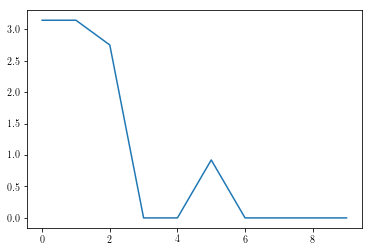

In [561]:
plt.plot(angles[0:10, 0]) # Looking at angle between unstable and neutral CLV
v1=CLVs[:,0,8]
v2=CLVs[:,1,8]
print(CLVs[:,0,8])
print(CLVs[:,1,8])
print(unit_vector(v1))
print(unit_vector(v2))

# Covariances

In [562]:
print(CLVs[:,0,0:13])
print(CLVs.shape)
print(np.where(np.isnan(CLVs)==True))
print(np.isnan(CLVs).nonzero())

[[-0.36971027  0.67777424  0.15499631 -0.48717689  0.709832    0.09887951
   0.04139371 -0.31959213 -1.23291235 -0.22336934  0.71035017 -0.36522885
   0.02796303]
 [-0.48188751  1.31590346  0.21323049 -0.47093007  1.25493604  0.17988651
   0.07600961 -0.35605436 -1.03244993 -0.03920083  0.34049024 -1.1616429
   0.45759236]
 [ 0.36221225  1.81598694  0.26843624 -0.56536122 -0.97047764 -0.02268423
  -0.04249081  0.32693456  4.75290705 -0.57696153  1.05396561  1.28211659
  -0.3703576 ]]
(3, 3, 3000)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


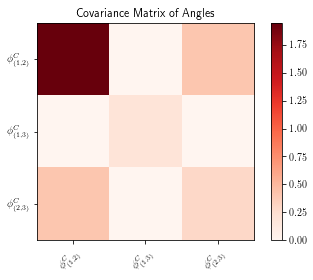

In [572]:
covm = np.cov(angles.T) # Calculating Pearson correlation coefficient
#use np.corrcoef for correlation

#Illustrating covariance matric as heatmap
fig, ax = plt.subplots() 
im = ax.imshow(covm, cmap='Reds')

names = np.array(['$\phi _{(1,2)}^C$', '$\phi _{(1,3)}^C$', '$\phi _{(2,3)}^C$']) # Labels
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Covariance Matrix of Angles")
cbar = plt.colorbar(im)# Colorbar
plt.savefig('Angles-Cov.png')